# Exploratory Data Analysis

## Import Libraries

In [3]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

# 1. Data Loading

### Load Data

In [4]:
df_identity = pd.read_csv('../datasets/train_identity.csv')
df_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
df_transaction = pd.read_csv('../datasets/train_transaction.csv')
df_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_dataset = pd.merge(df_transaction, df_identity, on='TransactionID', how='left')
df_dataset.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## 1.1 Verify shapes and columns

In [8]:
print("df_transaction shape:", df_transaction.shape)
print("df_transaction columns:", df_transaction.columns.tolist(), end="\n\n")

print("df_identity shape:", df_identity.shape)
print("df_identity columns:", df_identity.columns.tolist(), end="\n\n")

print("df_dataset (merged) shape:", df_dataset.shape)
print("df_dataset columns:", df_dataset.columns.tolist(), end="\n\n")


df_transaction shape: (590540, 394)
df_transaction columns: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73'

## 1.2 Check dtypes and convert object columns to 'category'

In [9]:
print("Before conversion (merged):")
print(df_dataset.dtypes.value_counts(), end="\n\n")

Before conversion (merged):
float64    399
object      31
int64        4
Name: count, dtype: int64



In [10]:
# Identify all object-typed columns
obj_cols = df_dataset.select_dtypes(include=['object']).columns.tolist()
print("Object-dtype columns to convert:", obj_cols, end="\n\n")

Object-dtype columns to convert: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']



In [11]:
# Convert them
for col in obj_cols:
    df_dataset[col] = df_dataset[col].astype('category')

print("After conversion (merged):")
print(df_dataset.dtypes.value_counts())

After conversion (merged):
float64     399
category     12
int64         4
category      4
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
Name: count, dtype: int64


# 2. Target Variable Exploration

## 2.1 Count and percentage of fraud vs. non-fraud

In [ ]:
fraud_counts = df_dataset['isFraud'].value_counts()
fraud_percent = df_dataset['isFraud'].value_counts(normalize=True) * 100

print("Fraud count:\n", fraud_counts, end="\n\n")
print("Fraud percentage:\n", fraud_percent, end="\n\n")

Fraud count:
 isFraud
0    569877
1     20663
Name: count, dtype: int64

Fraud percentage:
 isFraud
0    96.500999
1     3.499001
Name: proportion, dtype: float64



## 2.2 Pie chart of class distribution

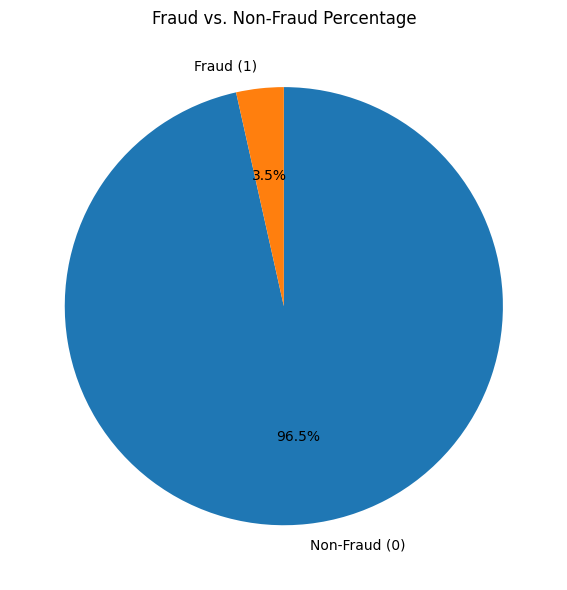

In [21]:
plt.figure(figsize=(6,6))
fraud_percent.plot.pie(
    autopct='%1.1f%%',
    labels=['Non-Fraud (0)', 'Fraud (1)'],
    startangle=90,
    counterclock=False
)
plt.ylabel('')
plt.title('Fraud vs. Non-Fraud Percentage')
plt.tight_layout()
plt.show()

# 3. Missingness Analysis

## 3.1 Compute percentage of missing values per column

In [22]:
missing_pct = df_dataset.isnull().mean() * 100
missing_pct = missing_pct.sort_values(ascending=False)

print("Top 20 columns by missing percentage:")
print(missing_pct.head(20), "\n")


Top 20 columns by missing percentage:
id_24    99.196159
id_25    99.130965
id_07    99.127070
id_08    99.127070
id_21    99.126393
id_26    99.125715
id_27    99.124699
id_23    99.124699
id_22    99.124699
dist2    93.628374
D7       93.409930
id_18    92.360721
D13      89.509263
D14      89.469469
D12      89.041047
id_03    88.768923
id_04    88.768923
D6       87.606767
id_33    87.589494
id_10    87.312290
dtype: float64 



## 3.2 Bar plot of the top 20 most-missing columns

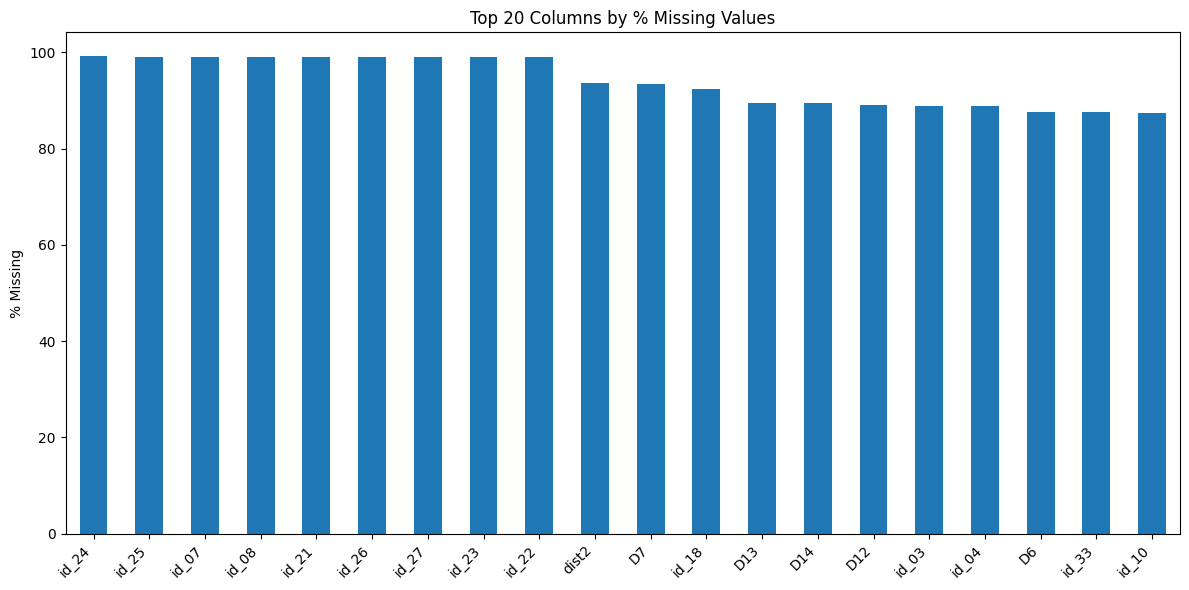

In [23]:
plt.figure(figsize=(12, 6))
missing_pct.head(20).plot.bar()
plt.title('Top 20 Columns by % Missing Values')
plt.ylabel('% Missing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3.3 Identify columns with >90% missing values

In [25]:
high_missing = missing_pct[missing_pct > 90]
print("Columns with >90% missing values:")
print(high_missing.index.tolist())

Columns with >90% missing values:
['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_27', 'id_23', 'id_22', 'dist2', 'D7', 'id_18']


# 4. Numeric Feature Univariate Analysis

## 4.1 Select a handful of key numeric features

In [26]:
num_feats = [
    'TransactionAmt',
    'dist1',
    'dist2',
    *[f'D{i}' for i in range(1, 6)]  # example: D1–D5
]

## 4.2 Summary statistics & skewness

In [27]:
stats = df_dataset[num_feats].describe().T
skewness = df_dataset[num_feats].skew()
print("Summary statistics:\n", stats, "\n")
print("Skewness:\n", skewness, "\n")

Summary statistics:
                    count        mean         std      min     25%     50%  \
TransactionAmt  590540.0  135.027176  239.162522    0.251  43.321  68.769   
dist1           238269.0  118.502180  371.872026    0.000   3.000   8.000   
dist2            37627.0  231.855423  529.053494    0.000   7.000  37.000   
D1              589271.0   94.347568  157.660387    0.000   0.000   3.000   
D2              309743.0  169.563231  177.315865    0.000  26.000  97.000   
D3              327662.0   28.343348   62.384721    0.000   1.000   8.000   
D4              421618.0  140.002441  191.096774 -122.000   0.000  26.000   
D5              280699.0   42.335965   89.000144    0.000   1.000  10.000   

                  75%        max  
TransactionAmt  125.0  31937.391  
dist1            24.0  10286.000  
dist2           206.0  11623.000  
D1              122.0    640.000  
D2              276.0    640.000  
D3               27.0    819.000  
D4              253.0    869.000  
D5   

## 4.3 Histograms with KDE

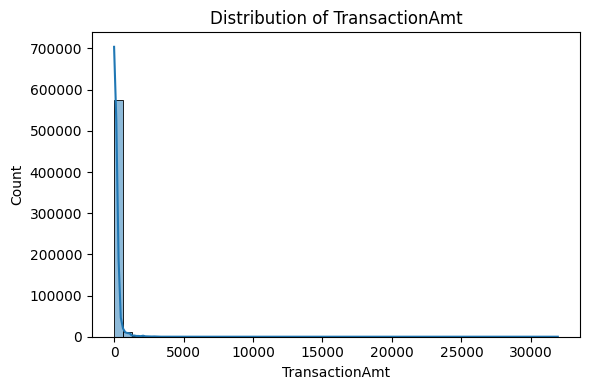

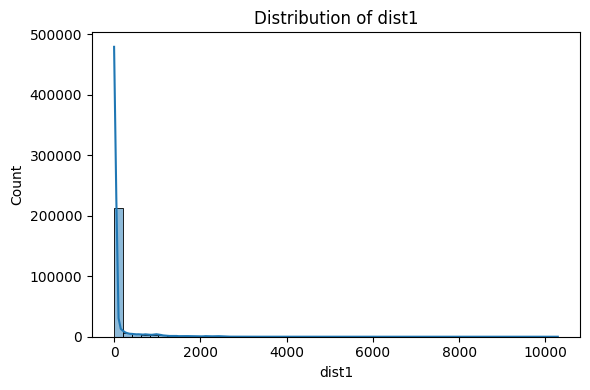

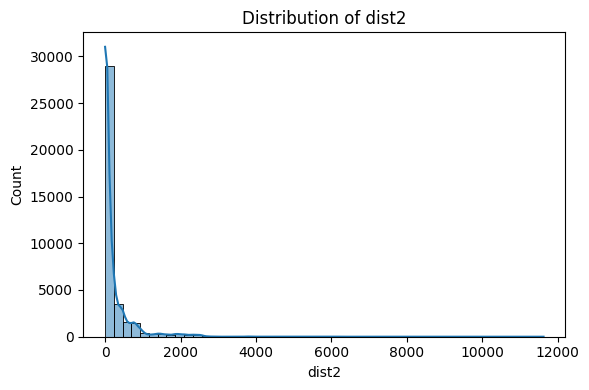

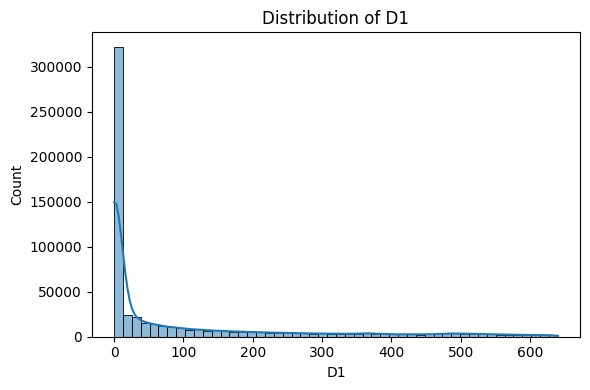

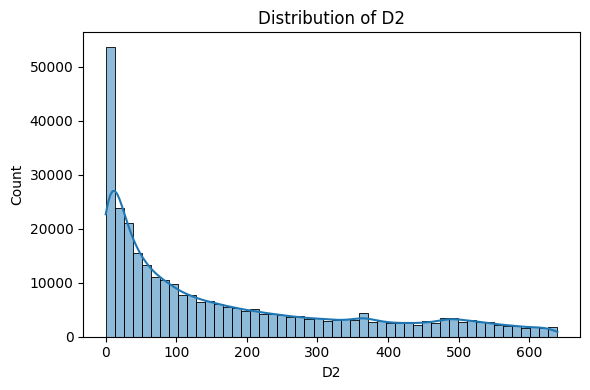

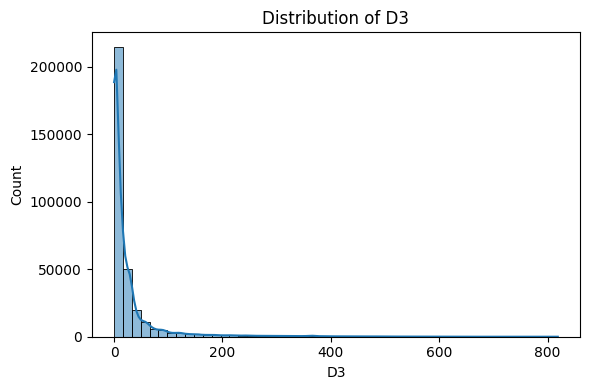

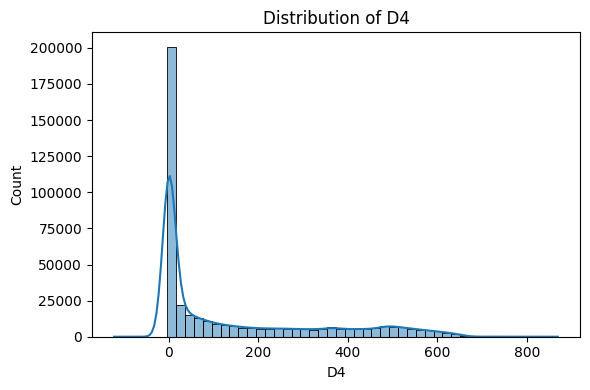

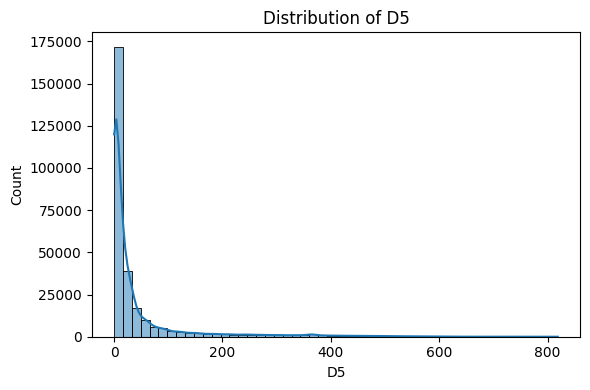

In [28]:
for col in num_feats:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_dataset[col].dropna(), bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# 5. Categorical Feature Univariate Analysis

## 5.1 Define key categorical columns


=== ProductCD ===
            count  percent
ProductCD                 
W          439670    74.45
C           68519    11.60
R           37699     6.38
H           33024     5.59
S           11628     1.97


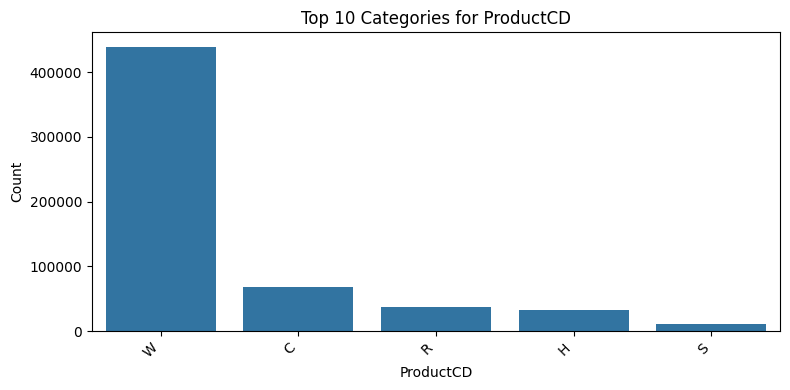


=== card4 ===
                   count  percent
card4                            
visa              384767    65.16
mastercard        189217    32.04
american express    8328     1.41
discover            6651     1.13
NaN                 1577     0.27


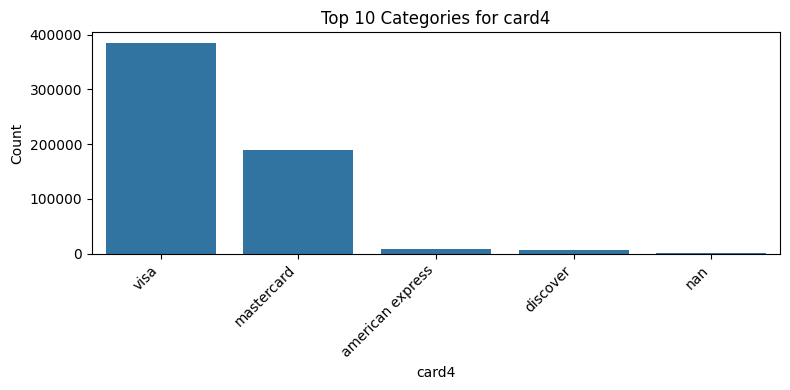


=== card6 ===
                  count  percent
card6                           
debit            439938    74.50
credit           148986    25.23
NaN                1571     0.27
debit or credit      30     0.01
charge card          15     0.00


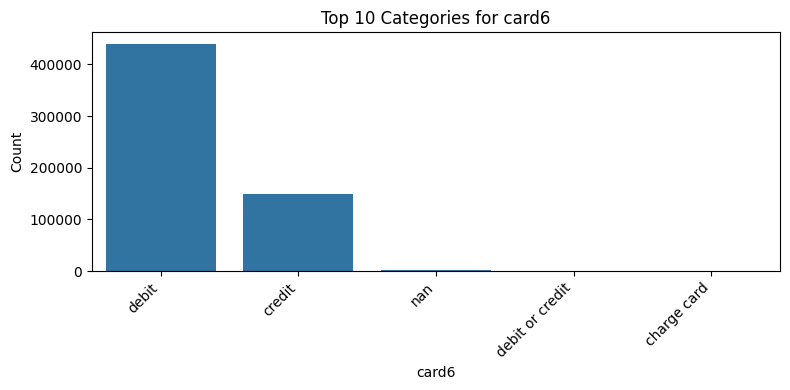


=== P_emaildomain ===
                count  percent
P_emaildomain                 
gmail.com      228355    38.67
yahoo.com      100934    17.09
NaN             94456    15.99
hotmail.com     45250     7.66
anonymous.com   36998     6.27
aol.com         28289     4.79
comcast.net      7888     1.34
icloud.com       6267     1.06
outlook.com      5096     0.86
msn.com          4092     0.69


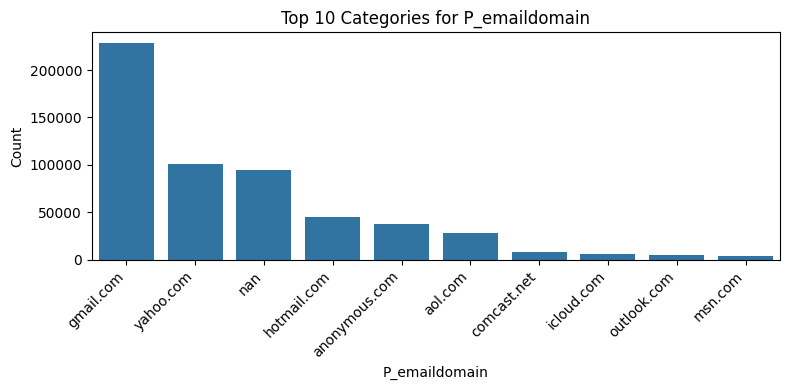


=== R_emaildomain ===
                count  percent
R_emaildomain                 
NaN            453249    76.75
gmail.com       57147     9.68
hotmail.com     27509     4.66
anonymous.com   20529     3.48
yahoo.com       11842     2.01
aol.com          3701     0.63
outlook.com      2507     0.42
comcast.net      1812     0.31
yahoo.com.mx     1508     0.26
icloud.com       1398     0.24


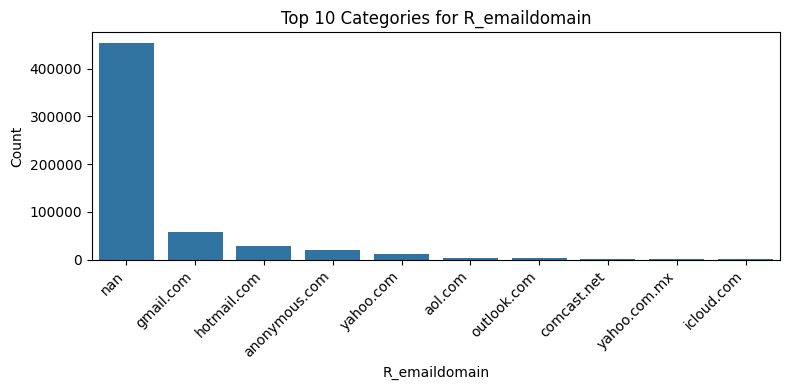


=== M1 ===
      count  percent
M1                  
T    319415    54.09
NaN  271100    45.91
F        25     0.00


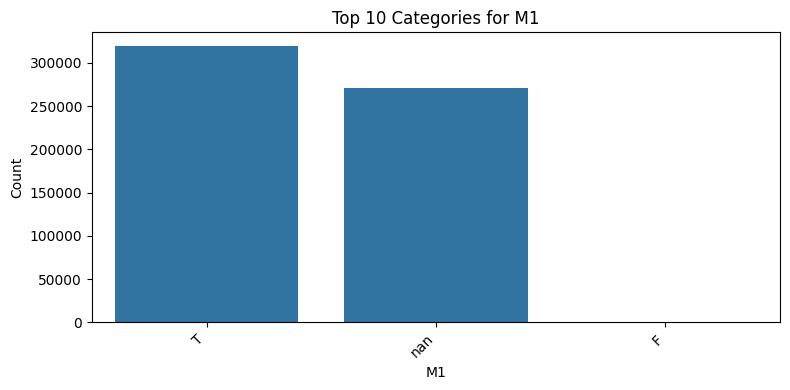


=== M2 ===
      count  percent
M2                  
T    285468    48.34
NaN  271100    45.91
F     33972     5.75


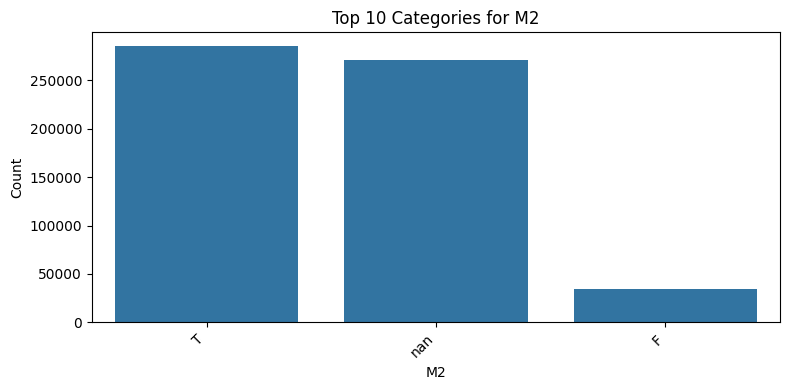


=== M3 ===
      count  percent
M3                  
NaN  271100    45.91
T    251731    42.63
F     67709    11.47


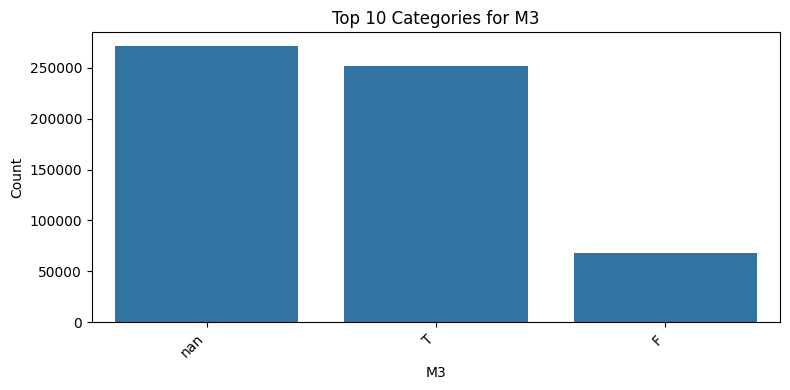


=== M4 ===
      count  percent
M4                  
NaN  281444    47.66
M0   196405    33.26
M2    59865    10.14
M1    52826     8.95


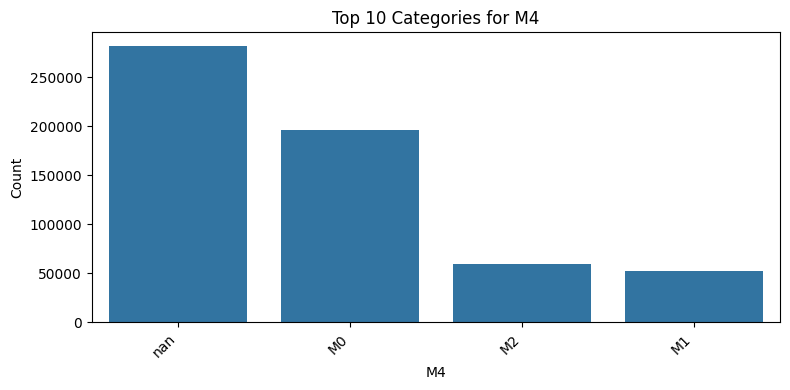


=== M5 ===
      count  percent
M5                  
NaN  350482    59.35
F    132491    22.44
T    107567    18.22


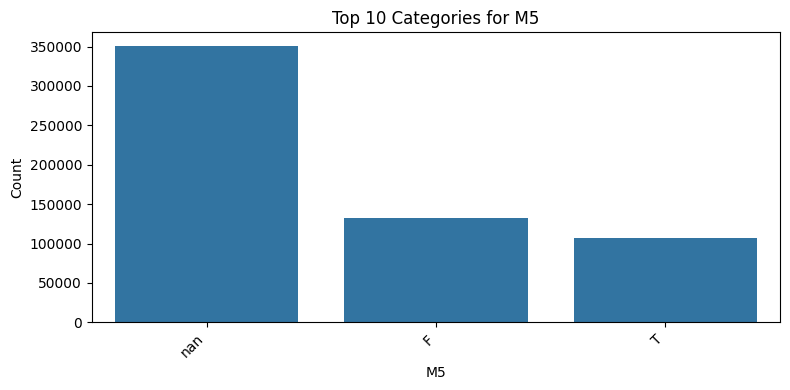


=== M6 ===
      count  percent
M6                  
F    227856    38.58
T    193324    32.74
NaN  169360    28.68


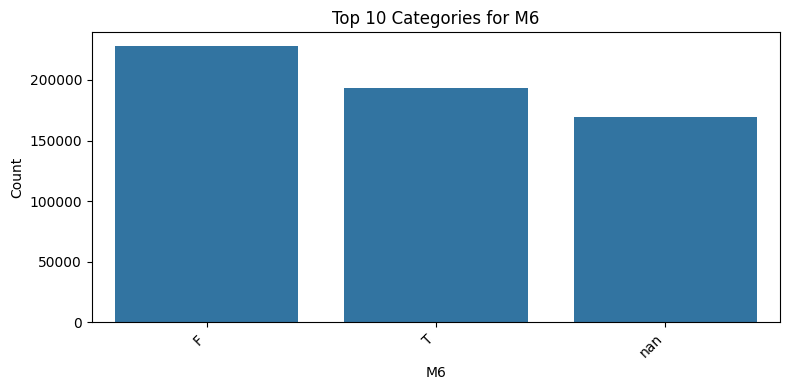


=== M7 ===
      count  percent
M7                  
NaN  346265    58.64
F    211374    35.79
T     32901     5.57


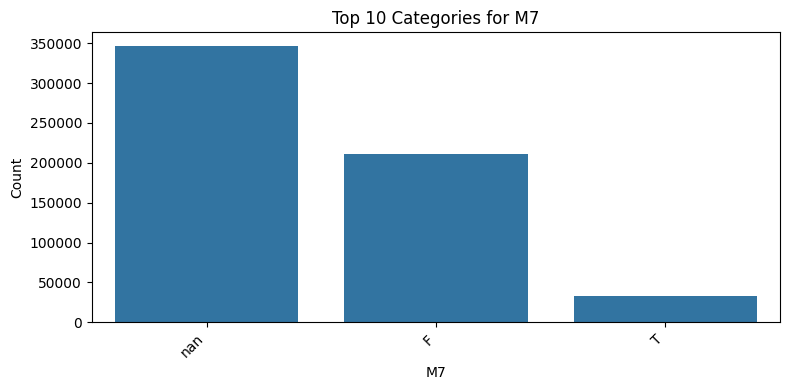


=== M8 ===
      count  percent
M8                  
NaN  346252    58.63
F    155251    26.29
T     89037    15.08


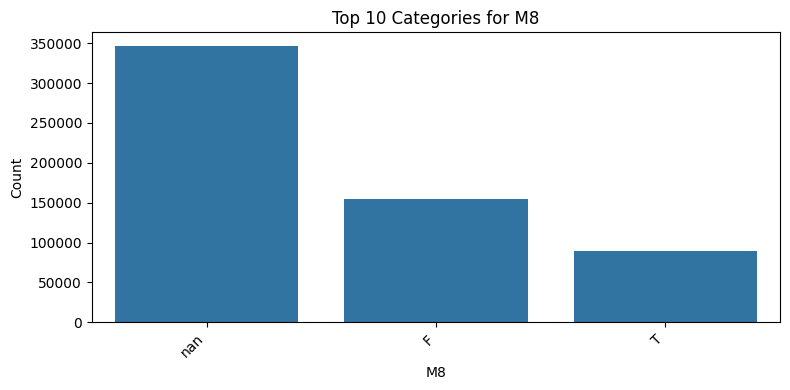


=== M9 ===
      count  percent
M9                  
NaN  346252    58.63
T    205656    34.83
F     38632     6.54


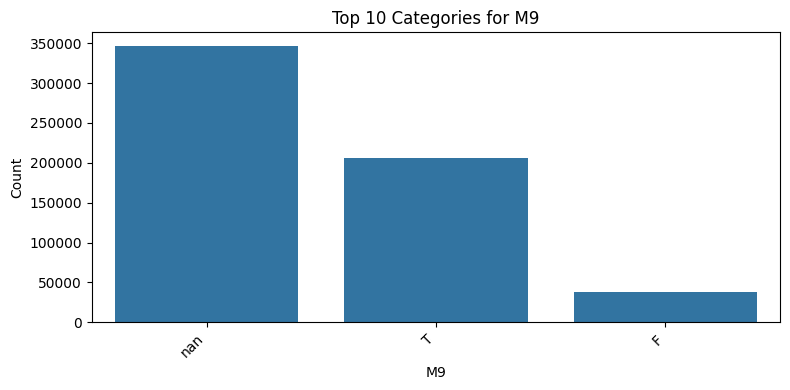


=== DeviceType ===
             count  percent
DeviceType                 
NaN         449730    76.16
desktop      85165    14.42
mobile       55645     9.42


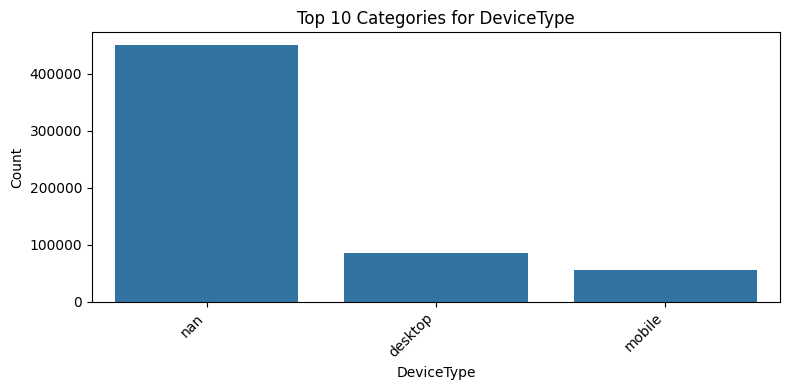


=== DeviceInfo ===
                        count  percent
DeviceInfo                            
NaN                    471874    79.91
Windows                 47722     8.08
iOS Device              19782     3.35
MacOS                   12573     2.13
Trident/7.0              7440     1.26
rv:11.0                  1901     0.32
rv:57.0                   962     0.16
SM-J700M Build/MMB29K     549     0.09
SM-G610M Build/MMB29K     461     0.08
SM-G531H Build/LMY48B     410     0.07


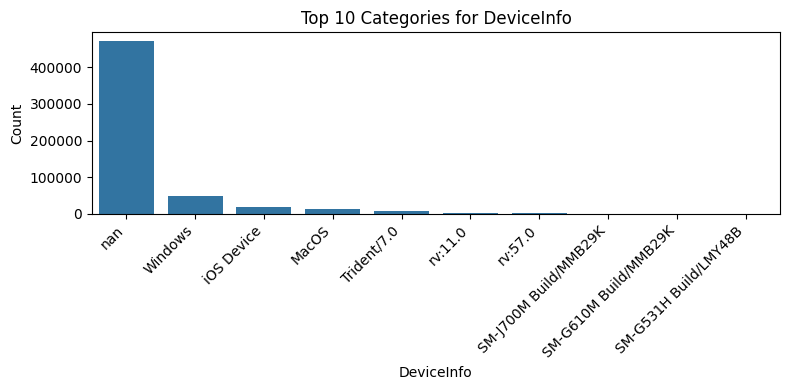

In [31]:
cat_feats = [
    'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
    *[f'M{i}' for i in range(1, 10)],  # M1–M9
    'DeviceType', 'DeviceInfo'
]

for col in cat_feats:
    print(f"\n=== {col} ===")
    # Frequency & percentage
    freq = df_dataset[col].value_counts(dropna=False)
    pct  = df_dataset[col].value_counts(normalize=True, dropna=False) * 100
    feat_df = pd.DataFrame({'count': freq, 'percent': pct.round(2)})
    print(feat_df.head(10))
    
    # Bar plot of top 10 categories
    plt.figure(figsize=(8, 4))
    sns.barplot(x=feat_df.head(10).index.astype(str),
                y='count',
                data=feat_df.head(10))
    plt.title(f'Top 10 Categories for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 6. Bivariate Analysis vs. Target

## 6.1 Numeric features vs isFraud

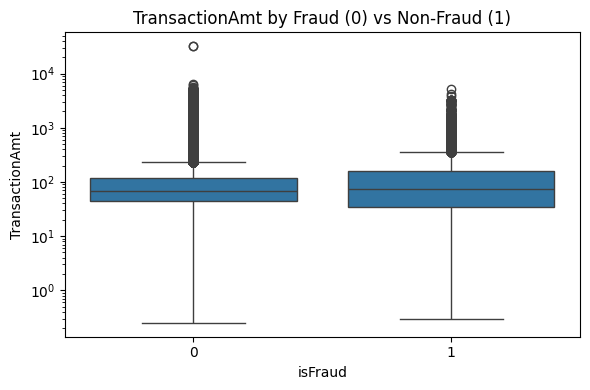

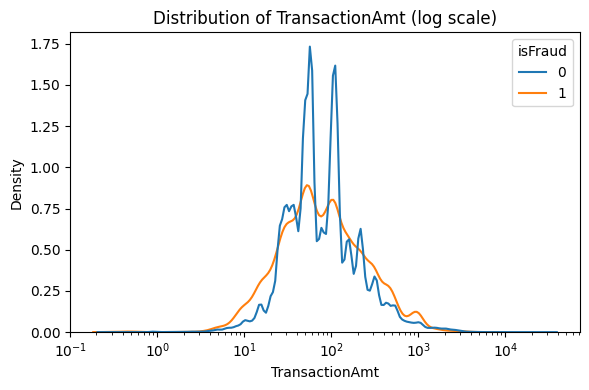

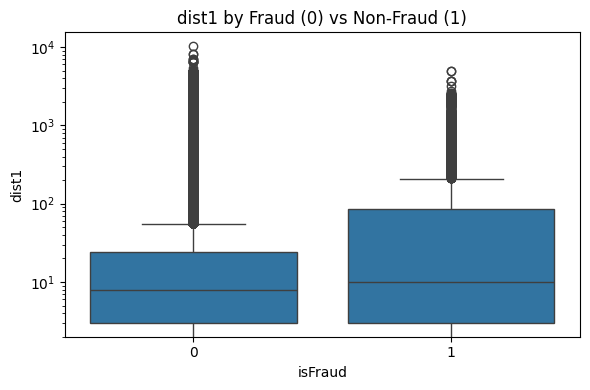

/var/folders/n2/9hl8ftpn3j379grs52lt_3q80000gn/T/ipykernel_5391/3479485237.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_dataset, x=col, hue='isFraud', common_norm=False, log_scale=True)


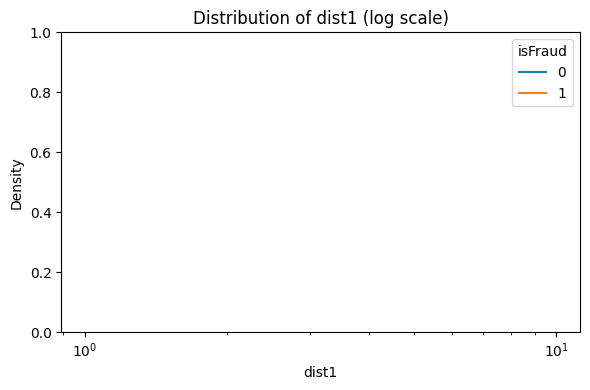

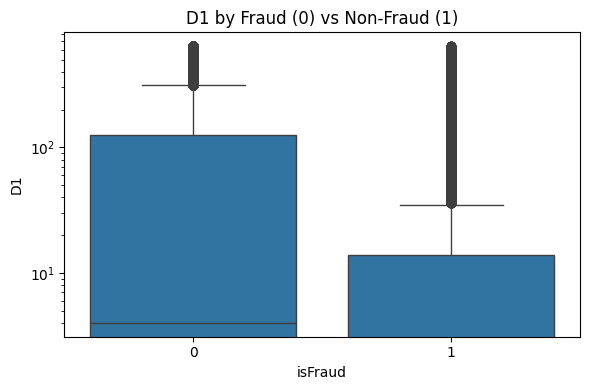

/var/folders/n2/9hl8ftpn3j379grs52lt_3q80000gn/T/ipykernel_5391/3479485237.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_dataset, x=col, hue='isFraud', common_norm=False, log_scale=True)


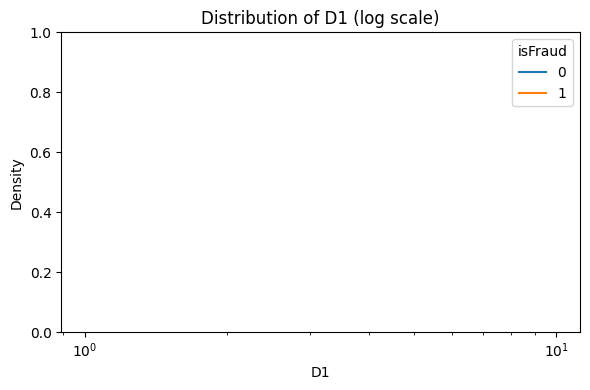

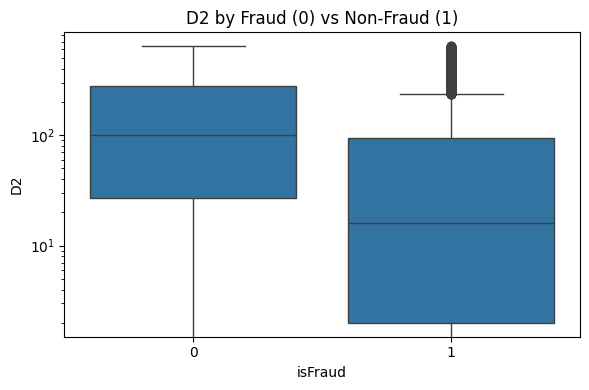

/var/folders/n2/9hl8ftpn3j379grs52lt_3q80000gn/T/ipykernel_5391/3479485237.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_dataset, x=col, hue='isFraud', common_norm=False, log_scale=True)


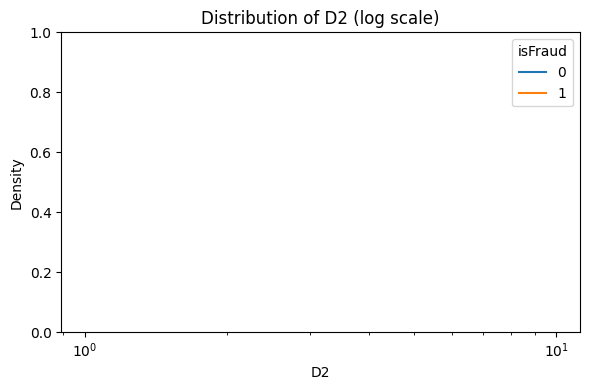

In [ ]:
num_feats = [
    'TransactionAmt',
    'dist1',
    # add more D-columns or other numerics as needed, e.g.
    'D1', 'D2'
]

for col in num_feats:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='isFraud', y=col, data=df_dataset)
    plt.yscale('log')                # log scale often helps with long tails
    plt.title(f'{col} by Fraud (0) vs Non-Fraud (1)')
    plt.xlabel('isFraud')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df_dataset, x=col, hue='isFraud', common_norm=False, log_scale=True)
    plt.title(f'Distribution of {col} (log scale)')
    plt.tight_layout()
    plt.show()

# 7. Temporal Analysis

## 7.1 Convert TransactionDT to datetime

In [33]:
ref_date = pd.to_datetime('2017-12-01')  # adjust if needed
df_dataset['TransactionDate'] = ref_date + pd.to_timedelta(df_dataset['TransactionDT'], unit='s')

# Extract time features
df_dataset['Txn_Day']  = df_dataset['TransactionDate'].dt.date
df_dataset['Txn_Hour'] = df_dataset['TransactionDate'].dt.hour
df_dataset['Txn_DOW']  = df_dataset['TransactionDate'].dt.dayofweek  # 0=Mon

## 7.2 Fraud rate over time

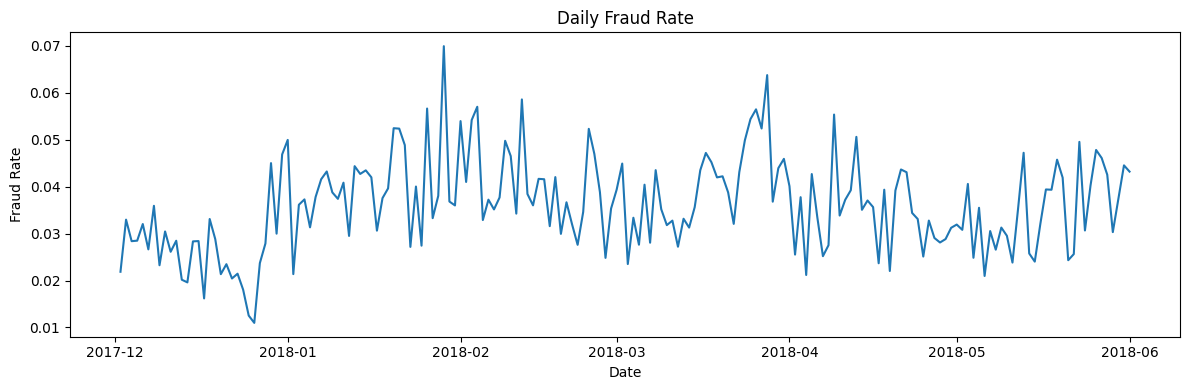

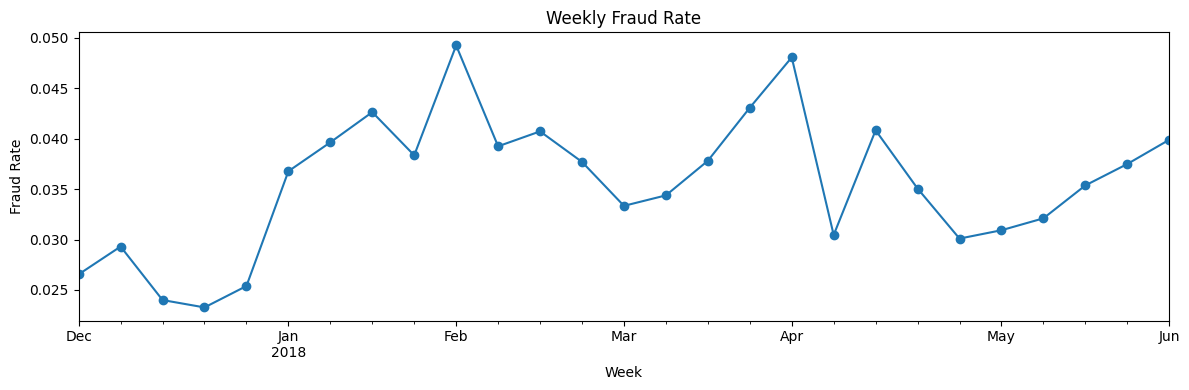

In [34]:
daily_rate  = df_dataset.groupby('Txn_Day')['isFraud'].mean()
weekly_rate = df_dataset.set_index('TransactionDate').resample('W')['isFraud'].mean()

plt.figure(figsize=(12,4))
daily_rate.plot()
plt.title('Daily Fraud Rate')
plt.ylabel('Fraud Rate')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
weekly_rate.plot(marker='o')
plt.title('Weekly Fraud Rate')
plt.ylabel('Fraud Rate')
plt.xlabel('Week')
plt.tight_layout()
plt.show()


## 7.3 Hour-of-day & day-of-week patterns

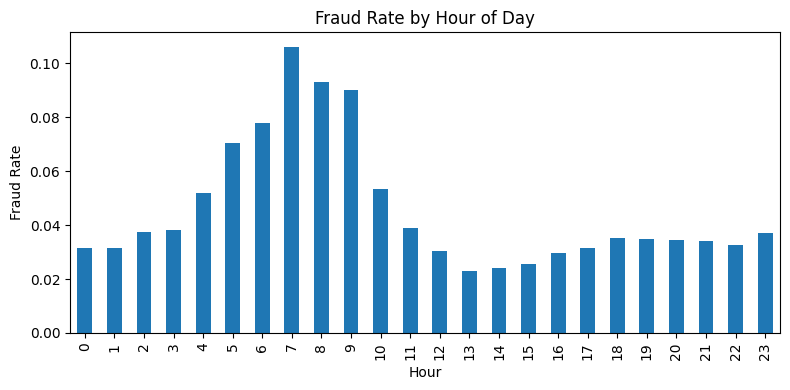

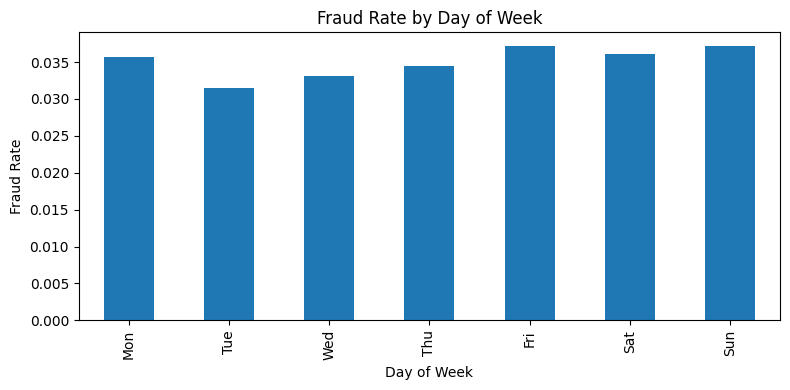

In [35]:
hourly_rate = df_dataset.groupby('Txn_Hour')['isFraud'].mean()
dow_rate    = df_dataset.groupby('Txn_DOW')['isFraud'].mean()
dow_rate.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

plt.figure(figsize=(8,4))
hourly_rate.plot(kind='bar')
plt.title('Fraud Rate by Hour of Day')
plt.ylabel('Fraud Rate')
plt.xlabel('Hour')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
dow_rate.plot(kind='bar')
plt.title('Fraud Rate by Day of Week')
plt.ylabel('Fraud Rate')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.show()

# 8. Feature Correlation & Redundancy

## 8.1 Select numeric features (exclude IDs and target)

In [36]:
num_cols = df_dataset.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude = ['TransactionID', 'isFraud', 'TransactionDT']
num_cols = [c for c in num_cols if c not in exclude]

## 8.2 Compute correlation matrix

In [37]:
corr = df_dataset[num_cols].corr()

## 8.3 Visualize with a masked heatmap

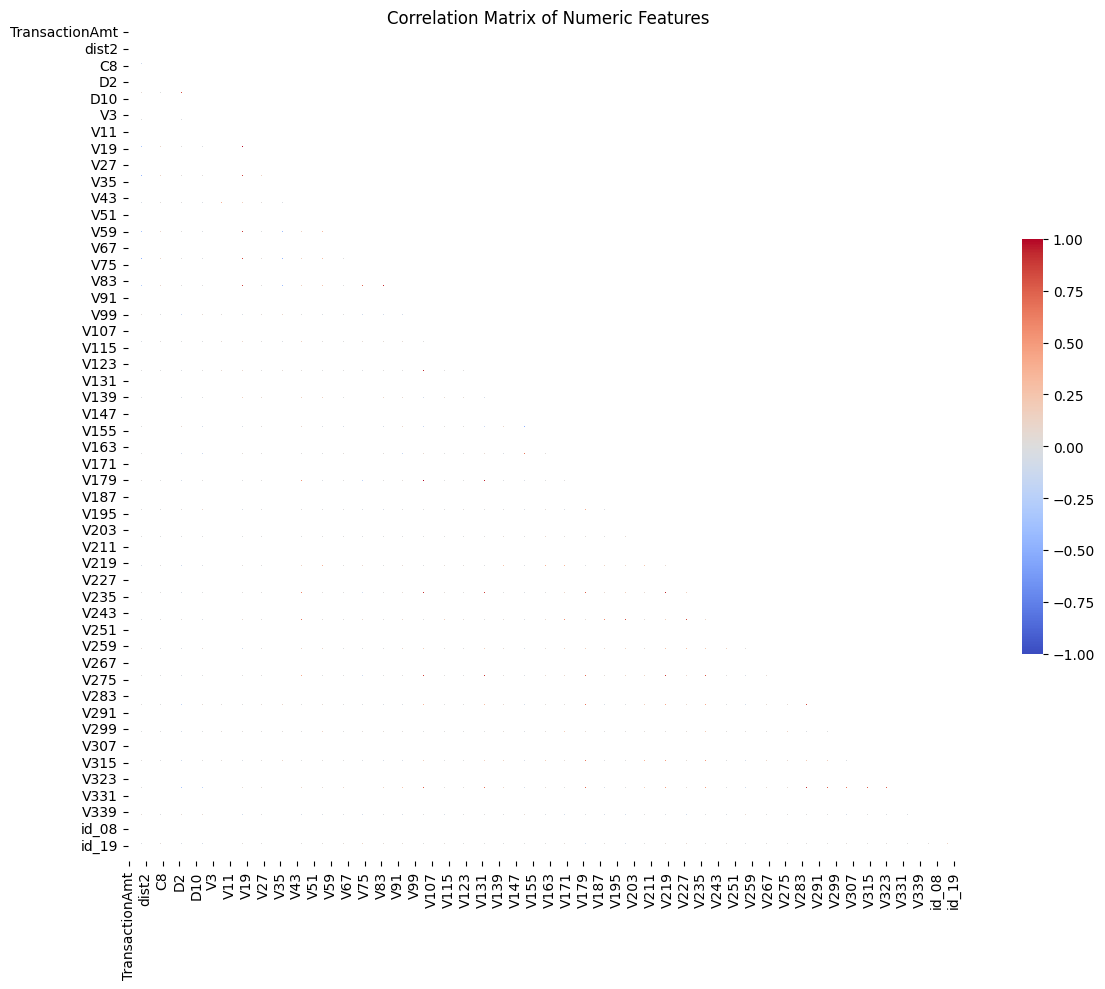

In [38]:
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr, 
    mask=mask, 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    linewidths=0.1, 
    cbar_kws={'shrink': .5}
)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

In [45]:
# Mask out the diagonal (self-correlations)
mask = np.eye(len(corr), dtype=bool)
corr_masked = corr.mask(mask)

# Unstack, sort, and grab the top pair
stacked = corr_masked.unstack().dropna()
highest_pair = stacked.idxmax()
highest_value = stacked.max()

print(f"Highest absolute correlation is between {highest_pair[0]} and {highest_pair[1]}, with |corr| = {highest_value:.6f}")

Highest absolute correlation is between D4 and D12, with |corr| = 0.999999


## 8.4 Identify highly correlated pairs

In [39]:
threshold = 0.90

# Unstack and filter
corr_pairs = (
    corr.abs()
        .unstack()
        .sort_values(ascending=False)
        .drop_duplicates()
)
high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > threshold)]

print("Pairs of features with |corr| > 0.9:")
print(high_corr)

Pairs of features with |corr| > 0.9:
D4    D12     0.999999
V95   V322    0.999949
V96   V323    0.999948
V324  V97     0.999947
V101  V322    0.999698
                ...   
V33   V74     0.900393
V233  V97     0.900293
V57   V74     0.900184
V59   V42     0.900030
V85   V63     0.900024
Length: 1376, dtype: float64


# 9. Missingness as Signal

## 9.1 Recompute missing percentages

In [69]:
missing_pct = df_dataset.isnull().mean() * 100

## 9.2 Select columns with >90% missing

In [70]:
signal_cols = missing_pct[missing_pct > 90].index.tolist()
print("Columns used as missingness signal:", signal_cols)

Columns used as missingness signal: ['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


## 9.3 Create missing-indicator flags


In [71]:
for col in signal_cols:
    df_dataset[f'{col}_missing'] = df_dataset[col].isnull().astype(int)

## 9.4 Plot fraud rate for missing vs. non-missing

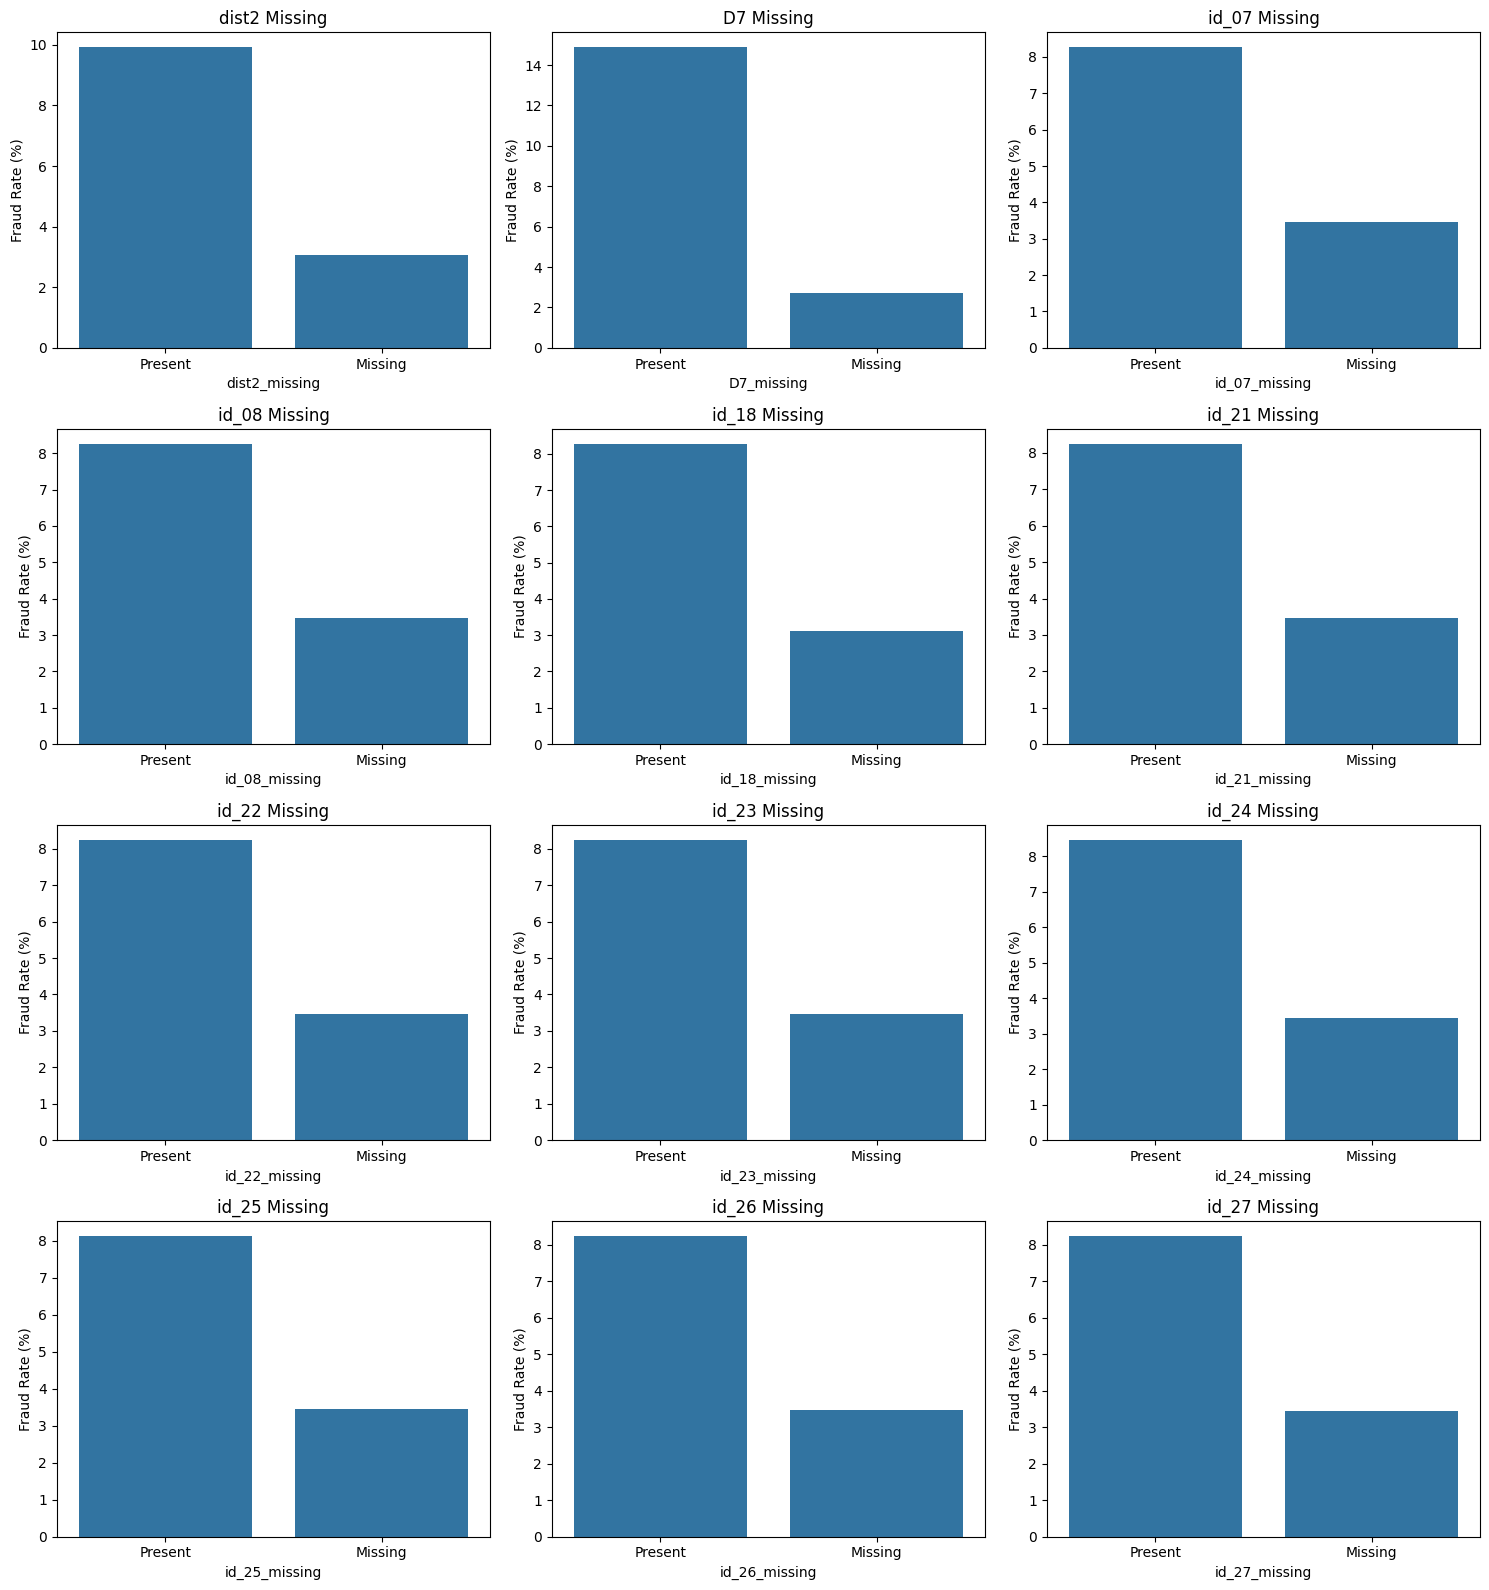

In [74]:
# Prepare subplots
n = len(signal_cols)
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for ax, col in zip(axes, signal_cols):
    flag = f'{col}_missing'
    rates = df_dataset.groupby(flag)['isFraud'].mean()
    sns.barplot(x=rates.index, y=rates.values * 100, ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Present', 'Missing'])
    ax.set_ylabel('Fraud Rate (%)')
    ax.set_title(f'{col} Missing')

# Disable any extra empty plots
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()